In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/healthcare analytics 2/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/healthcare analytics 2/test.csv')

In [6]:
#Check for the Nan values in the dataset
train.isna().sum(),test.isna().sum()

(case_id                                 0
 Hospital_code                           0
 Hospital_type_code                      0
 City_Code_Hospital                      0
 Hospital_region_code                    0
 Available Extra Rooms in Hospital       0
 Department                              0
 Ward_Type                               0
 Ward_Facility_Code                      0
 Bed Grade                             113
 patientid                               0
 City_Code_Patient                    4532
 Type of Admission                       0
 Severity of Illness                     0
 Visitors with Patient                   0
 Age                                     0
 Admission_Deposit                       0
 Stay                                    0
 dtype: int64, case_id                                 0
 Hospital_code                           0
 Hospital_type_code                      0
 City_Code_Hospital                      0
 Hospital_region_code                   

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
#Remove Nan values and labelencode the target variable
train.fillna(999,inplace=True),test.fillna(999,inplace=True)
le = LabelEncoder()
train['Stay']=le.fit_transform(train['Stay'].astype(str))

In [8]:
#Merge the test and train columns to get a combined dataset
df = pd.concat([train,test])
df.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0.0
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,4.0
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,3.0
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,4.0
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,4.0


In [9]:
#Count the number of unique values in the dataset
df.nunique()

case_id                              455495
Hospital_code                            32
Hospital_type_code                        7
City_Code_Hospital                       11
Hospital_region_code                      3
Available Extra Rooms in Hospital        18
Department                                5
Ward_Type                                 6
Ward_Facility_Code                        6
Bed Grade                                 5
patientid                            131624
City_Code_Patient                        38
Type of Admission                         3
Severity of Illness                       3
Visitors with Patient                    29
Age                                      10
Admission_Deposit                      7634
Stay                                     11
dtype: int64

## Feature Engineering

Due to a large number of categorical variables, we had to create lot of groups to extract information from the columns.

For deciding the variables to create the groups on, we first threw the original dataset for the prediction and then chose the most important columns using feature importance plot.

In [10]:
#GROUPS ON DURATION OF STAY
#Groups on Stay on the basis of hospital type
group = df.groupby(['Hospital_code','Hospital_type_code','City_Code_Hospital','Hospital_region_code']).agg(hospital_stay_cnt = ('Stay','count'))
df = pd.merge(df,group,on=['Hospital_code','Hospital_type_code','City_Code_Hospital','Hospital_region_code'],how='left')

#Groups on Stay on the basis of the ward conditions
group = df.groupby(['Available Extra Rooms in Hospital','Ward_Type','Ward_Facility_Code','Bed Grade']).agg(ward_stay_cnt=('Stay','count'))
df = pd.merge(df,group,on=['Available Extra Rooms in Hospital','Ward_Type','Ward_Facility_Code','Bed Grade'],how='left')

#Groups on Stay on the basis of type of illness of the patient
group = df.groupby(['Type of Admission','Severity of Illness','Department','Age']).agg(illness_stay_cnt = ('Stay','count'))
df = pd.merge(df,group,on=['Type of Admission','Severity of Illness','Department','Age'],how='left')

In [11]:
#GROUPS ON NUMBER OF VISITORS WITH PATIENT
#Groups on the number of visitors with patient on the basis of ward conditions
group = df.groupby(['Ward_Type','Ward_Facility_Code','Bed Grade'])['Visitors with Patient'].agg(visitor_ward=('Visitors with Patient','count'))
df = pd.merge(df,group,on=['Ward_Type','Ward_Facility_Code','Bed Grade'],how='left')

#Counting the min,max and avergae number of visitors with each patient
group = df.groupby(['patientid'])['Visitors with Patient'].agg(['mean','min','max'])
group.columns = [x + '_visitor_patient' for x in group.columns.ravel()]
df = pd.merge(df,group,on='patientid',how='left')

#Counting the min,max and average number of visitors with patients on the basis of available rooms
group = df.groupby(['Available Extra Rooms in Hospital'])['Visitors with Patient'].agg(['mean','min','max'])
group.columns = [x + '_visitor_rooms' for x in group.columns.ravel()]
df = pd.merge(df,group,on='Available Extra Rooms in Hospital',how='left')

#Counting the min,max and average number of visitors with patients on the basis of the city codes of the patient
group = df.groupby(['City_Code_Patient'])['Visitors with Patient'].agg(['mean','min','max'])
group.columns = [x + '_visitor_citypat' for x in group.columns.ravel()]
df = pd.merge(df,group,on='City_Code_Patient',how='left')

In [12]:
#GROUPS ON ADMISSION DEPOSIT
#Average,min,max and standard deviation of admission deposit by each patient
group = df.groupby(['patientid'])['Admission_Deposit'].agg(['mean','min','max','std'])
group.columns = [x + '_deposit_pat' for x in group.columns.ravel()]
df = pd.merge(df,group,on='patientid',how='left')

#Average,min,max and standard deviation of admission deposit by visitors with each patient
group = df.groupby(['Visitors with Patient'])['Admission_Deposit'].agg(['mean','min','max','std'])
group.columns = [x + '_deposit_visitor' for x in group.columns.ravel()]
df = pd.merge(df,group,on='Visitors with Patient',how='left')

#Average,min,max and standard deviation of admission deposit by patient city code
group = df.groupby(['City_Code_Patient'])['Admission_Deposit'].agg(['mean','min','max','std'])
group.columns = [x + '_deposit_citypat' for x in group.columns.ravel()]
df = pd.merge(df,group,on='City_Code_Patient',how='left')

#Average,min,max and standard deviation of admission deposit by illness type
groups = df.groupby(['Department','Type of Admission','Severity of Illness'])['Admission_Deposit'].agg(['mean','min','max','std'])
groups.columns = [x + '_deposit_illness' for x in groups.columns.ravel()]
df = pd.merge(df,groups,on=['Department','Type of Admission','Severity of Illness'],how='left')

#Average,min,max and standard deviation of admission deposit by hospital type
groups = df.groupby(['Hospital_code','Hospital_type_code','City_Code_Hospital','Hospital_region_code'])['Admission_Deposit'].agg(['mean','min','max','std'])
groups.columns = [x + '_deposit_hospital' for x in groups.columns.ravel()]
df = pd.merge(df,groups,on=['Hospital_code','Hospital_type_code','City_Code_Hospital','Hospital_region_code'],how='left')

#Average,min,max and standard deviation of admission deposit by hospital code
groups = df.groupby(['Hospital_type_code','Hospital_code'])['Admission_Deposit'].agg(['mean','min','max','std'])
groups.columns = [x + '_deposit_hosp_code' for x in groups.columns.ravel()]
df = pd.merge(df,groups,on=['Hospital_type_code','Hospital_code'],how='left')

#Average,min,max and standard deviation of admission deposit by hospital region
group = df.groupby(['Hospital_region_code','City_Code_Hospital'])['Admission_Deposit'].agg(['mean','min','max','std'])
group.columns = [x + '_deposit_place_type' for x in group.columns.ravel()]
df = pd.merge(df,group,on=['Hospital_region_code','City_Code_Hospital'],how='left')

#Average,min,max and standard deviation of admission deposit by age of patient
group = df.groupby(['Age'])['Admission_Deposit'].agg(['mean','min','max','std'])
group.columns = [x + '_deposit_age' for x in group.columns.ravel()]
df = pd.merge(df,group,on=['Age'],how='left')

In [13]:
#GROUPS ON PATIENT ID
#Number of patient ids in city code patient
group = df.groupby('City_Code_Patient').agg(citypat_cnt=('patientid','count'))
df = pd.merge(df,group,on=['City_Code_Patient'],how='left')

#Number of unique patients per city code patient
group = df.groupby('City_Code_Patient').agg(citypat_cnt_unique=('patientid','nunique'))
df = pd.merge(df,group,on=['City_Code_Patient'],how='left')

#Number of patient ids per severity per admission type
group = df.groupby(['Type of Admission','Severity of Illness']).agg(illnes_pat_cnt=('patientid','count'))
df = pd.merge(df,group,on=['Type of Admission','Severity of Illness'],how='left')

#Number of unique patients per severity per admission type
group = df.groupby(['Type of Admission','Severity of Illness']).agg(illnes_pat_cnt_unique=('patientid','nunique'))
df = pd.merge(df,group,on=['Type of Admission','Severity of Illness'],how='left')

#Number of departments, hospitals by code, hospitals and age by the patient
for i in ['Department','Hospital_code','Hospital_type_code','Age']:
  group = df.groupby(['patientid']).agg(**{f'{i}_pat_cnt_unique':pd.NamedAgg(column=i,aggfunc='nunique')})
  df = pd.merge(df,group,on=['patientid'],how='left')

In [ ]:
#These features decreased the model accuracy score initially but seem to be increasing the score in private leaderboard for the other model
'''
df['ratio_deposit_visitors'] = df['Admission_Deposit']/df['Visitors with Patient']
df['ratio_deposit_rooms'] = df['Admission_Deposit']/df['Available Extra Rooms in Hospital']
df['ratio_rooms_visitors'] = df['Available Extra Rooms in Hospital']/df['Visitors with Patient']
'''

"\ndf['ratio_deposit_visitors'] = df['Admission_Deposit']/df['Visitors with Patient']\ndf['ratio_deposit_rooms'] = df['Admission_Deposit']/df['Available Extra Rooms in Hospital']\ndf['ratio_rooms_visitors'] = df['Available Extra Rooms in Hospital']/df['Visitors with Patient']\n"

In [14]:
#Labelencoding the categorical variables
le_var = LabelEncoder()
col = ['Hospital_type_code','Hospital_region_code','Department','Ward_Type','Ward_Facility_Code','Type of Admission','Severity of Illness','Age']
for i in col:
  df[i] = le_var.fit_transform(df[i])

In [15]:
X = df[df['Stay'].notnull()]
X_valid = df[df['Stay'].isnull()]

## Model Training

In [17]:
#Using the XGBoost Model for training
xgbc2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=563, n_jobs=-1,
              nthread=4, num_class=11, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, silent=None, subsample=0.8, verbosity=1)

xgbc2.fit(X.drop(columns=['case_id','Stay']),X['Stay'])

y_pred_xgbc2 = xgbc2.predict(X_valid.drop(columns=['case_id','Stay']))

test_res = test[['case_id']]
test_res_xgbc2 = pd.concat([test_res,pd.DataFrame(y_pred_xgbc2,columns=['Stay'],dtype=np.int64)],axis=1)
test_res_xgbc2['Stay'] = le.inverse_transform(test_res_xgbc2['Stay'])
test_res_xgbc2.set_index(['case_id'],inplace=True)
test_res_xgbc2.to_csv('/content/drive/My Drive/Colab Notebooks/healthcare analytics 2/sub_xgbc5.csv')

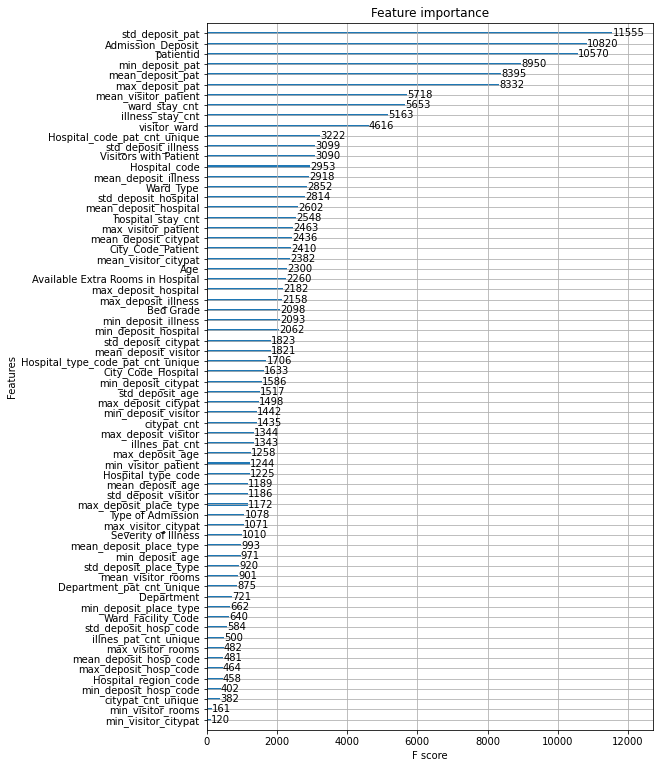

In [18]:
#Feature Importance
plt.rcParams['figure.figsize']= (8,13)
xgb.plot_importance(xgbc2)